In [11]:
import pandas as pd
import numpy as np
from os import listdir
from os.path import isfile, join
import matplotlib.pyplot as plt


def decode_feature_string(feature_string):
    feature_string = feature_string.split("[")[1]
    flist = feature_string.split("-")
    embedding_method = flist[1]
    merge_features = flist[2]
    add_degree = flist[3]
    compute_node_embeddings = flist[4]
    time_series_feature_set = flist[5]
    if time_series_feature_set == "empty":
        time_series_feature_set = ""
    if add_degree == "False":
        add_degree = ""
    elif add_degree == "True":
        add_degree = "D"

    if compute_node_embeddings == "True":
        if merge_features == "True":
            main_text = f"{time_series_feature_set}\n{embedding_method}"
        elif merge_features == "False":
            main_text = embedding_method
    elif compute_node_embeddings == "False":
        main_text = time_series_feature_set

    final_feature_label = f"{main_text}\n{add_degree}"
    return final_feature_label


def nlargest_and_plot(dftemp, metric, tail=False):
    metrics_list = ['Accuracy', 'Balanced_accuracy_score', 'F1macro', 'F1micro',
       'F1weighted', 'MCC', 'precision', 'recall_score']
    dftemp[metrics_list] = dftemp[metrics_list].astype(np.float)
    
    nsmallest_metric = dftemp[[metric, "x_names"]].nsmallest(len(dftemp), metric)
    if tail:
        nsmallest_metric = nsmallest_metric.tail(tail)
    print(nsmallest_metric)
    x = nsmallest_metric["x_names"]
    y = nsmallest_metric[metric]
    fig = plt.figure(figsize=(20,3), dpi=150)
    plt.scatter(x, y)
    plt.show()

In [36]:
# LOAD DATASET
# file_folder = "hcp_17_51"
# file_folder = "mutag"
# file_folder = "uj_gpu"
file_folder = "hcp_rs_lr_102"
# file_folder = 'hcp_17_49'
# file_folder = "hcp_17_ex"

file_folder = f"./training_visualizations/{file_folder}"
    
file_list = [f for f in listdir(file_folder) if isfile(join(file_folder, f))]
file_list = [f"{file_folder}/{x}" for x in file_list]

file_ident = "metric_results"

metric_results_file_list = [x for x in file_list if file_ident in x]
# display(metric_results_file_list)

# CREATE A SINGLE DF WITH ALL RESULTS
dffinal = pd.DataFrame()
for file in metric_results_file_list:
    df = pd.read_excel(file)
    df = df.T
    df.columns = df.loc["Unnamed: 0"]
    df.drop("Unnamed: 0", axis=0, inplace=True)
    df.index = [file.split("/")[-1][len(file_folder.split("/")[-1])+1:-len(file_ident)-6]]
    dffinal = pd.concat([dffinal, df], axis=0)
    
# DECODE VALUES OF PARAMETERS  
ifl = 0
dffinal["Threshold"] = [f"{x.split('_')[ifl]}" for x in dffinal.index.tolist()]
if dffinal.index.tolist()[0].find("empty") != -1:
    ifl += 1
                        
dffinal["Hidden Channels"] = [f"{x.split('_')[ifl+2]}" for x in dffinal.index.tolist()]

dffinal["Features"] = [f"{decode_feature_string(x)}" for x in dffinal.index.tolist()]                       
dffinal["Model"] = [f"{x.split('_')[ifl+6]}" for x in dffinal.index.tolist()]  
dffinal["Graph type"] = [f"{x.split('_')[ifl+8]}" for x in dffinal.index.tolist()]
dffinal["Batch size"] = [f"{x.split('_')[ifl+9]}" for x in dffinal.index.tolist()]
                    
name_cols = ["Threshold", "Hidden Channels", "Features", "Model", "Batch size", "Graph type"]                       
dffinal["x_names"] = ["\n".join(dffinal.loc[dffinal.index.tolist(), name_cols].values.tolist()[x]) for x in range(len(dffinal))]


In [37]:
display(dffinal["x_names"])

-2_0.0001_256_500_4267_False_SAGENET_0_maxst_64_[-Feather-True-False-True-mixed-]        -2\n256\nmixed\nFeather\n\nSAGENET\n64\nmaxst
-2_0.0001_512_500_49_False_GCN_0_maxst_32_[-NodeSketch-True-False-True-mixed-]            -2\n512\nmixed\nNodeSketch\n\nGCN\n32\nmaxst
-2_0.0001_256_500_49_True_GCNe_0_maxst_32_[-NodeSketch-True-False-True-mixed-]           -2\n256\nmixed\nNodeSketch\n\nGCNe\n32\nmaxst
-2_0.0001_128_500_4267_False_GCN_0_maxst_64_[-Feather-True-False-True-mixed-]                -2\n128\nmixed\nFeather\n\nGCN\n64\nmaxst
-2_0.0001_128_500_49_False_GCN_0_maxst_32_[-NodeSketch-True-False-True-mixed-]            -2\n128\nmixed\nNodeSketch\n\nGCN\n32\nmaxst
-2_0.0001_128_500_49_True_GCNe_0_maxst_32_[-NodeSketch-True-False-True-mixed-]           -2\n128\nmixed\nNodeSketch\n\nGCNe\n32\nmaxst
-2_0.0001_256_500_49_False_SAGENET_0_maxst_32_[-NodeSketch-True-False-True-mixed-]    -2\n256\nmixed\nNodeSketch\n\nSAGENET\n32\nmaxst
-2_0.0001_128_500_49_True_GCNe_0_full_32_[-NodeSketch-T

In [38]:
def show_only(x):
    if x.find("_GNN_") != -1:
        if x.find("_maxst_") != -1:
            if x.find("_128_") != -1:
                return True
    else:
        return False        

In [39]:
dffinal["x_names"][0].replace('\n', '')

'-2256mixedFeatherSAGENET64maxst'

Unnamed: 0                                          Accuracy  \
-2_0.0001_128_500_4267_False_GCN_0_maxst_32_[-F...  0.740741   
-2_0.0001_256_500_4267_False_GCN_0_maxst_32_[-F...  0.753086   
-2_0.0001_512_500_4267_False_GCN_0_maxst_32_[-F...  0.703704   

Unnamed: 0                                         Balanced_accuracy_score  \
-2_0.0001_128_500_4267_False_GCN_0_maxst_32_[-F...                0.735565   
-2_0.0001_256_500_4267_False_GCN_0_maxst_32_[-F...                0.749079   
-2_0.0001_512_500_4267_False_GCN_0_maxst_32_[-F...                0.697174   

Unnamed: 0                                           F1macro   F1micro  \
-2_0.0001_128_500_4267_False_GCN_0_maxst_32_[-F...  0.736728  0.740741   
-2_0.0001_256_500_4267_False_GCN_0_maxst_32_[-F...  0.750000  0.753086   
-2_0.0001_512_500_4267_False_GCN_0_maxst_32_[-F...  0.698137  0.703704   

Unnamed: 0                                         F1weighted       MCC  \
-2_0.0001_128_500_4267_False_GCN_0_maxst_32_[-F...   0.739

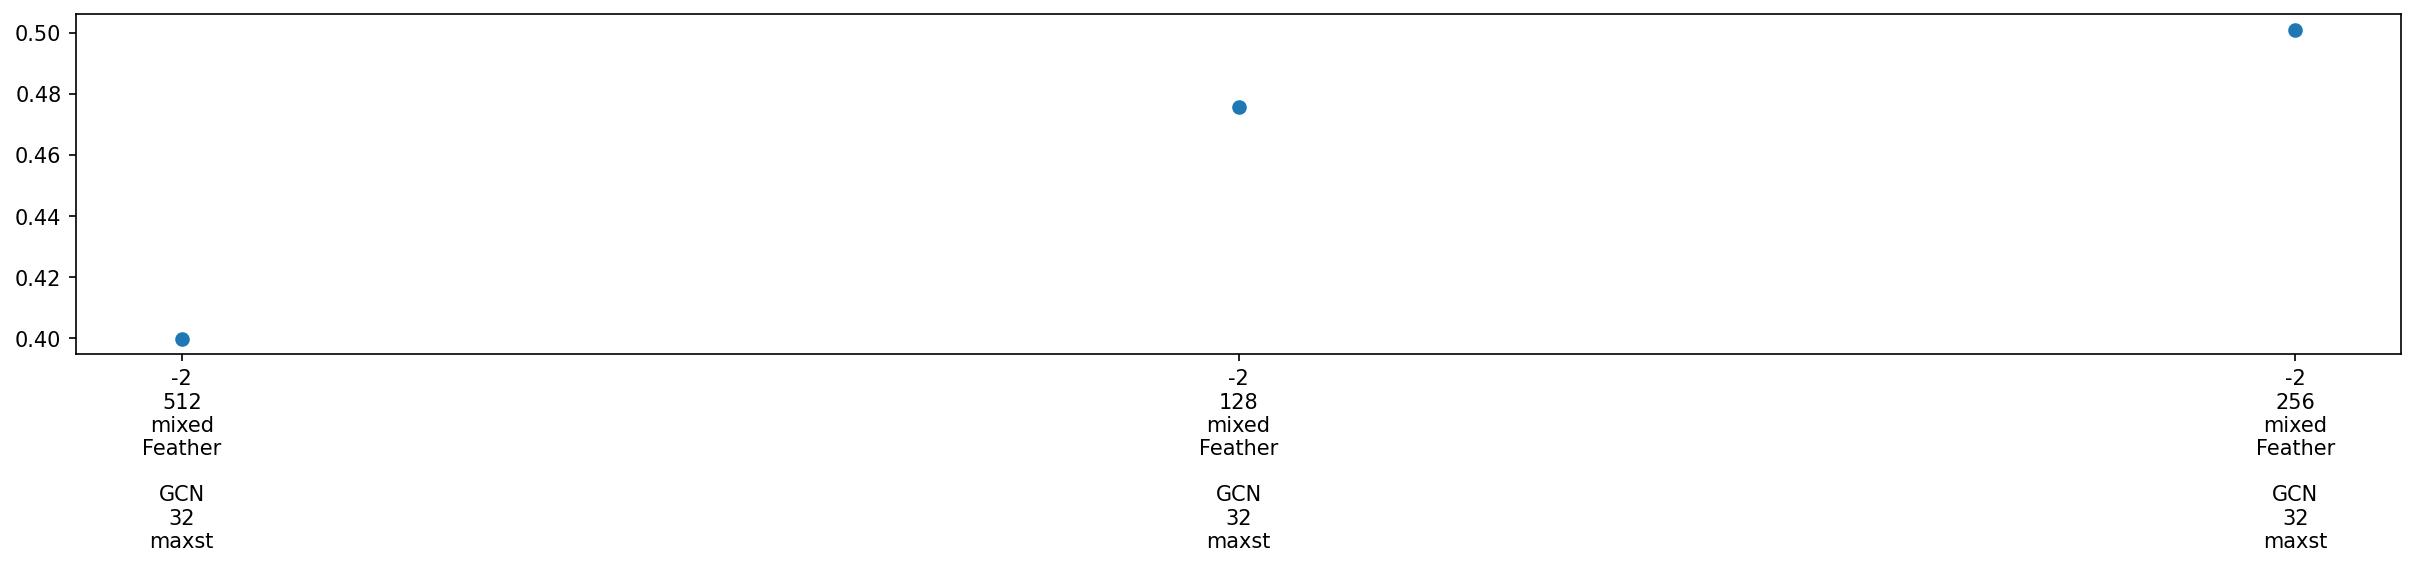

Unnamed: 0                                          Accuracy  \
-2_0.0001_512_500_4267_True_GCNe_0_maxst_32_[-F...  0.703704   
-2_0.0001_256_500_4267_True_GCNe_0_maxst_32_[-F...  0.716049   
-2_0.0001_128_500_4267_True_GCNe_0_maxst_32_[-F...  0.691358   

Unnamed: 0                                         Balanced_accuracy_score  \
-2_0.0001_512_500_4267_True_GCNe_0_maxst_32_[-F...                0.688575   
-2_0.0001_256_500_4267_True_GCNe_0_maxst_32_[-F...                0.699939   
-2_0.0001_128_500_4267_True_GCNe_0_maxst_32_[-F...                0.675061   

Unnamed: 0                                           F1macro   F1micro  \
-2_0.0001_512_500_4267_True_GCNe_0_maxst_32_[-F...  0.686452  0.703704   
-2_0.0001_256_500_4267_True_GCNe_0_maxst_32_[-F...  0.697614  0.716049   
-2_0.0001_128_500_4267_True_GCNe_0_maxst_32_[-F...  0.671320  0.691358   

Unnamed: 0                                         F1weighted       MCC  \
-2_0.0001_512_500_4267_True_GCNe_0_maxst_32_[-F...   0.692

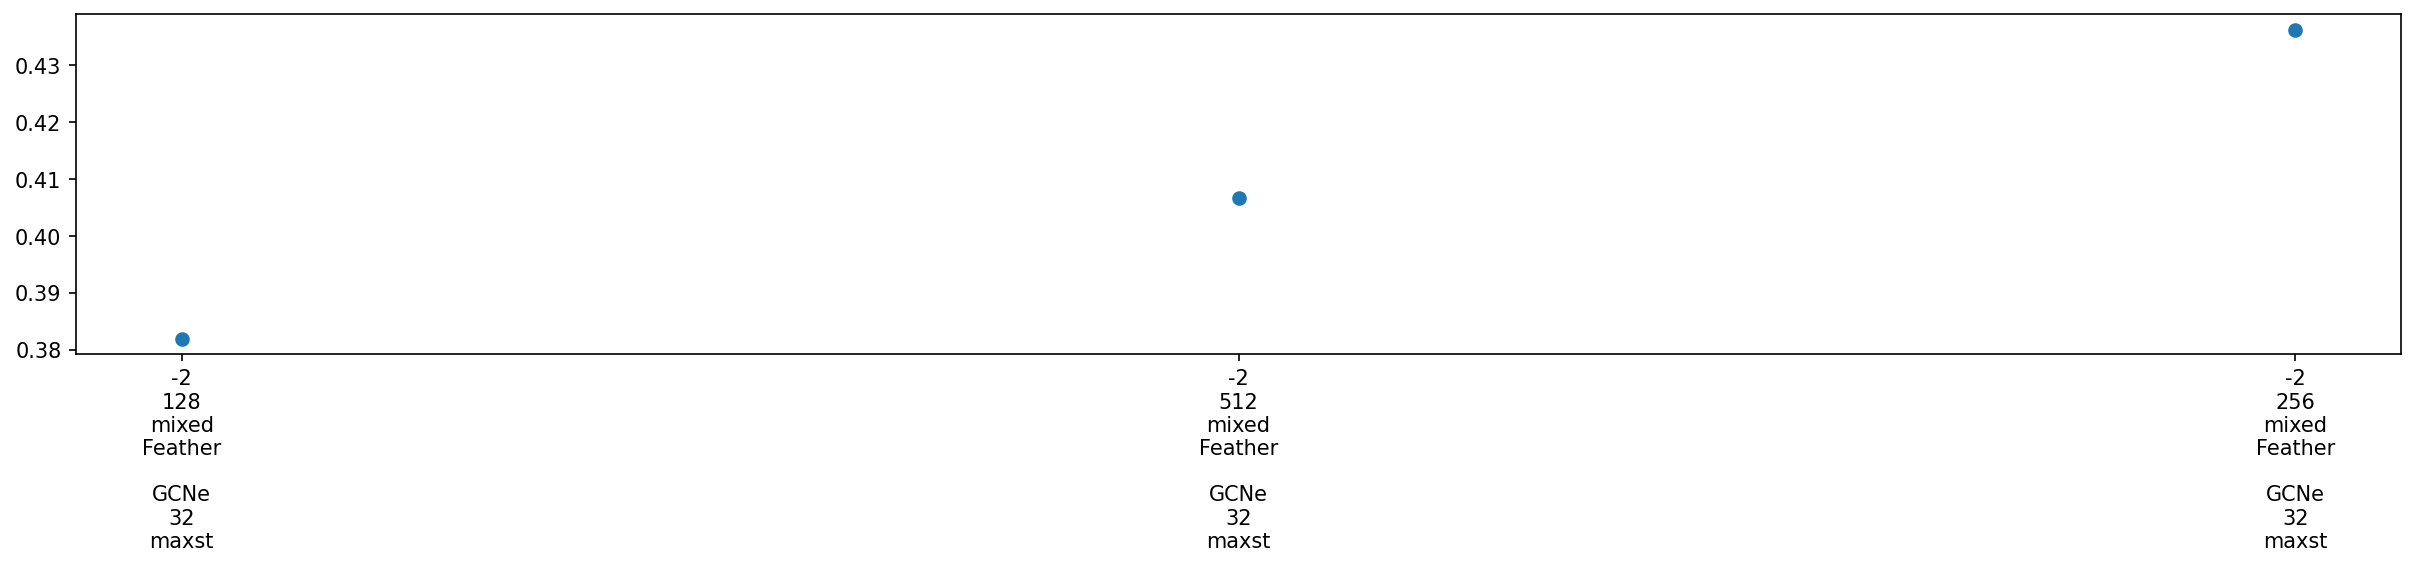

Unnamed: 0                                          Accuracy  \
-2_0.0001_512_500_4267_False_SAGENET_0_maxst_32...  0.740741   
-2_0.0001_256_500_4267_False_SAGENET_0_maxst_32...  0.629630   
-2_0.0001_128_500_4267_False_SAGENET_0_maxst_32...  0.691358   

Unnamed: 0                                         Balanced_accuracy_score  \
-2_0.0001_512_500_4267_False_SAGENET_0_maxst_32...                0.731265   
-2_0.0001_256_500_4267_False_SAGENET_0_maxst_32...                0.598894   
-2_0.0001_128_500_4267_False_SAGENET_0_maxst_32...                0.672912   

Unnamed: 0                                           F1macro   F1micro  \
-2_0.0001_512_500_4267_False_SAGENET_0_maxst_32...  0.732757  0.740741   
-2_0.0001_256_500_4267_False_SAGENET_0_maxst_32...  0.555921  0.629630   
-2_0.0001_128_500_4267_False_SAGENET_0_maxst_32...  0.666776  0.691358   

Unnamed: 0                                         F1weighted       MCC  \
-2_0.0001_512_500_4267_False_SAGENET_0_maxst_32...   0.736

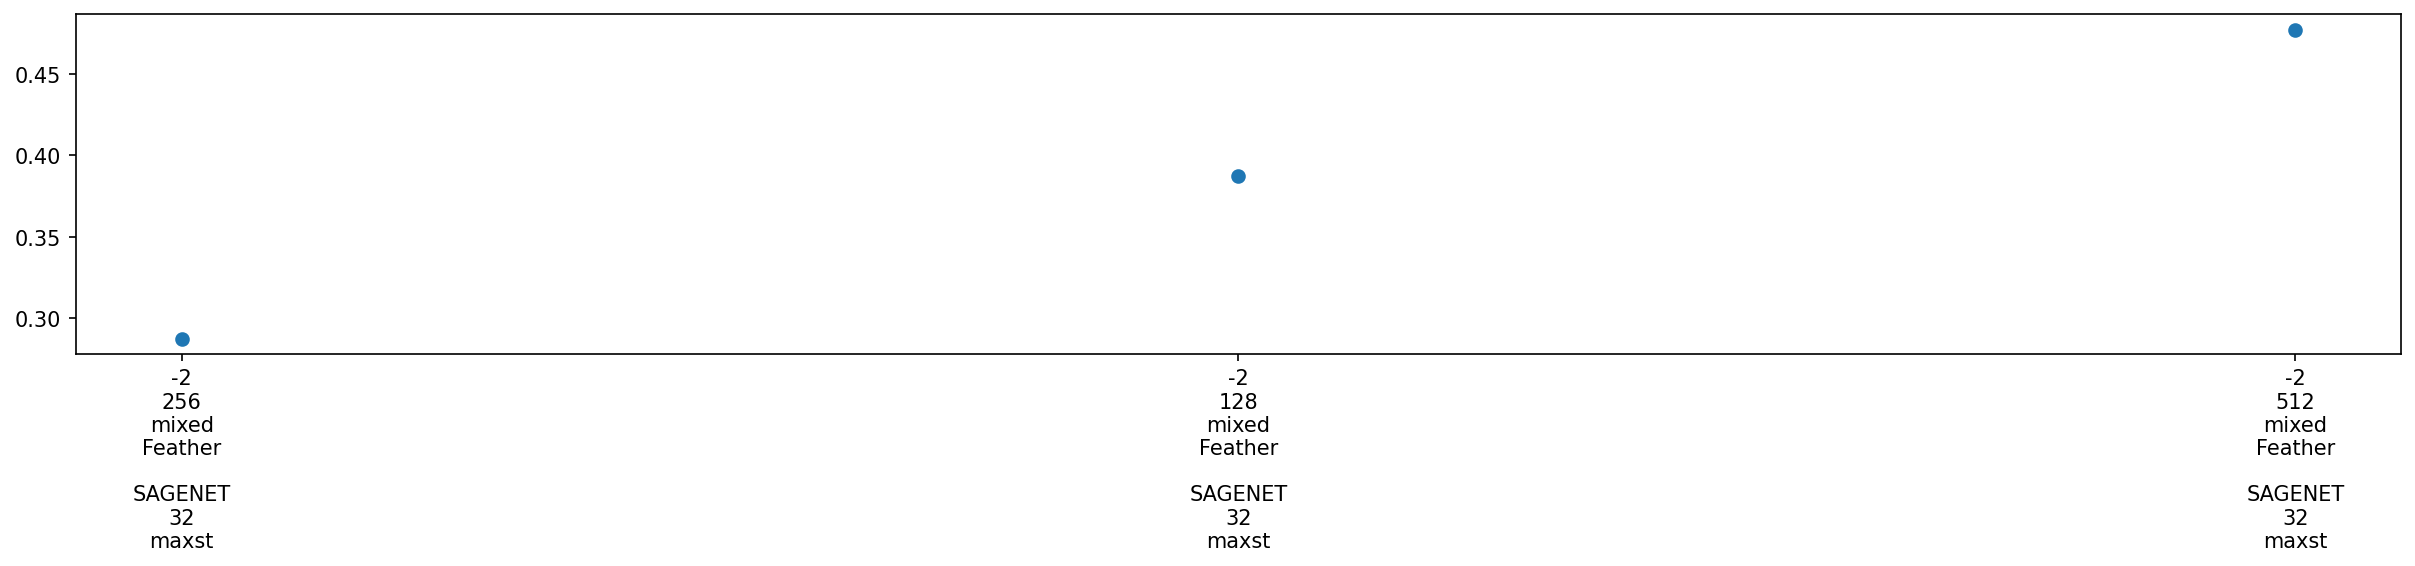

Unnamed: 0                                          Accuracy  \
-2_0.0001_512_500_49_False_GCN_0_maxst_32_[-Nod...  0.679012   
-2_0.0001_128_500_49_False_GCN_0_maxst_32_[-Nod...  0.543210   
-2_0.0001_128_500_49_False_GCN_0_full_32_[-Node...  0.580247   
-2_0.0001_256_500_49_False_GCN_0_maxst_32_[-Nod...  0.765432   
-2_0.0001_512_500_49_False_GCN_0_full_32_[-Node...  0.580247   
-2_0.0001_256_500_49_False_GCN_0_full_32_[-Node...  0.592593   

Unnamed: 0                                         Balanced_accuracy_score  \
-2_0.0001_512_500_49_False_GCN_0_maxst_32_[-Nod...                0.680897   
-2_0.0001_128_500_49_False_GCN_0_maxst_32_[-Nod...                0.500000   
-2_0.0001_128_500_49_False_GCN_0_full_32_[-Node...                0.500000   
-2_0.0001_256_500_49_False_GCN_0_maxst_32_[-Nod...                0.762592   
-2_0.0001_512_500_49_False_GCN_0_full_32_[-Node...                0.549140   
-2_0.0001_256_500_49_False_GCN_0_full_32_[-Node...                0.556204   

Unna

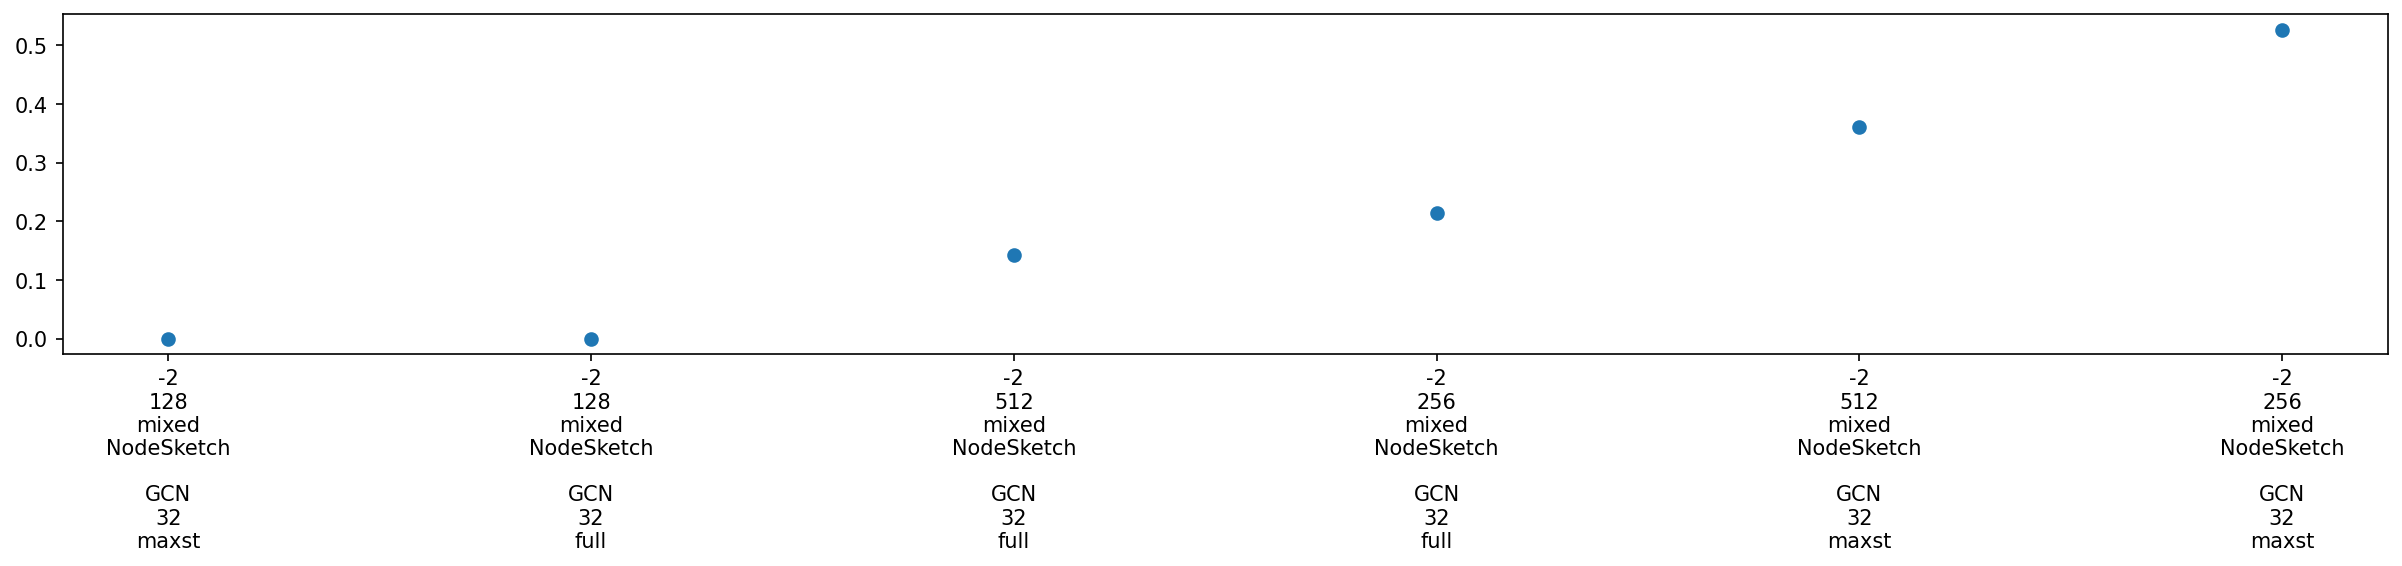

Unnamed: 0                                          Accuracy  \
-2_0.0001_256_500_49_True_GCNe_0_maxst_32_[-Nod...  0.604938   
-2_0.0001_128_500_49_True_GCNe_0_maxst_32_[-Nod...  0.629630   
-2_0.0001_128_500_49_True_GCNe_0_full_32_[-Node...  0.580247   
-2_0.0001_256_500_49_True_GCNe_0_full_32_[-Node...  0.580247   
-2_0.0001_512_500_49_True_GCNe_0_maxst_32_[-Nod...  0.666667   

Unnamed: 0                                         Balanced_accuracy_score  \
-2_0.0001_256_500_49_True_GCNe_0_maxst_32_[-Nod...                0.574017   
-2_0.0001_128_500_49_True_GCNe_0_maxst_32_[-Nod...                0.601044   
-2_0.0001_128_500_49_True_GCNe_0_full_32_[-Node...                0.551290   
-2_0.0001_256_500_49_True_GCNe_0_full_32_[-Node...                0.542690   
-2_0.0001_512_500_49_True_GCNe_0_maxst_32_[-Nod...                0.643735   

Unnamed: 0                                           F1macro   F1micro  \
-2_0.0001_256_500_49_True_GCNe_0_maxst_32_[-Nod...  0.526316  0.604938  

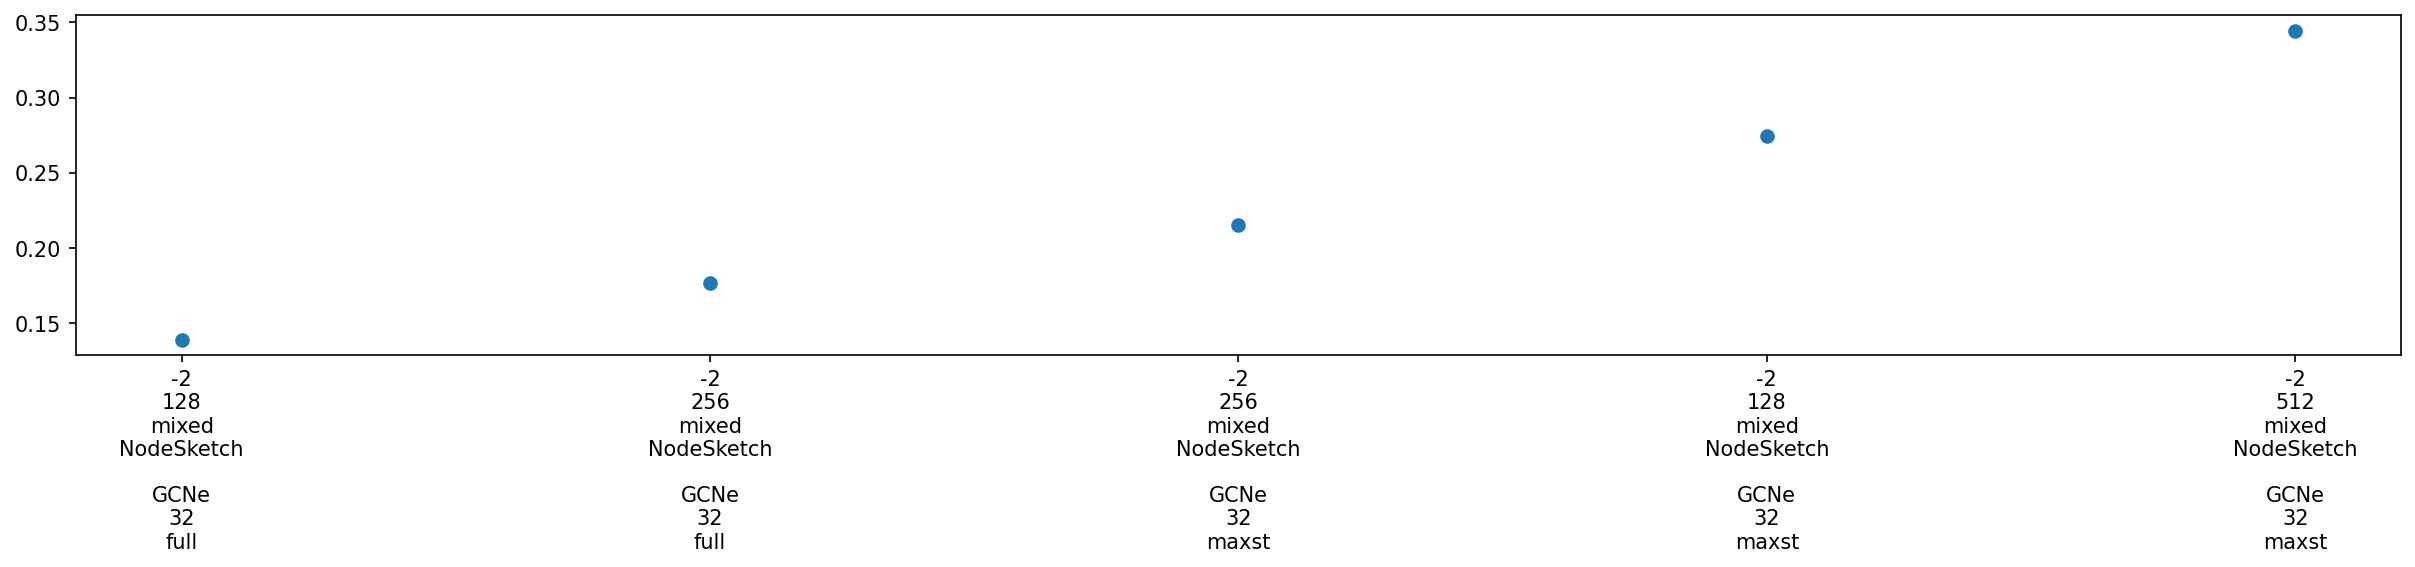

Unnamed: 0                                          Accuracy  \
-2_0.0001_256_500_49_False_SAGENET_0_maxst_32_[...  0.617284   
-2_0.0001_512_500_49_False_SAGENET_0_full_32_[-...  0.617284   
-2_0.0001_128_500_49_False_SAGENET_0_maxst_32_[...  0.641975   
-2_0.0001_128_500_49_False_SAGENET_0_full_32_[-...  0.617284   
-2_0.0001_256_500_49_False_SAGENET_0_full_32_[-...  0.617284   
-2_0.0001_512_500_49_False_SAGENET_0_maxst_32_[...  0.666667   

Unnamed: 0                                         Balanced_accuracy_score  \
-2_0.0001_256_500_49_False_SAGENET_0_maxst_32_[...                0.609029   
-2_0.0001_512_500_49_False_SAGENET_0_full_32_[-...                0.589681   
-2_0.0001_128_500_49_False_SAGENET_0_maxst_32_[...                0.621007   
-2_0.0001_128_500_49_False_SAGENET_0_full_32_[-...                0.587531   
-2_0.0001_256_500_49_False_SAGENET_0_full_32_[-...                0.587531   
-2_0.0001_512_500_49_False_SAGENET_0_maxst_32_[...                0.663084   

Unna

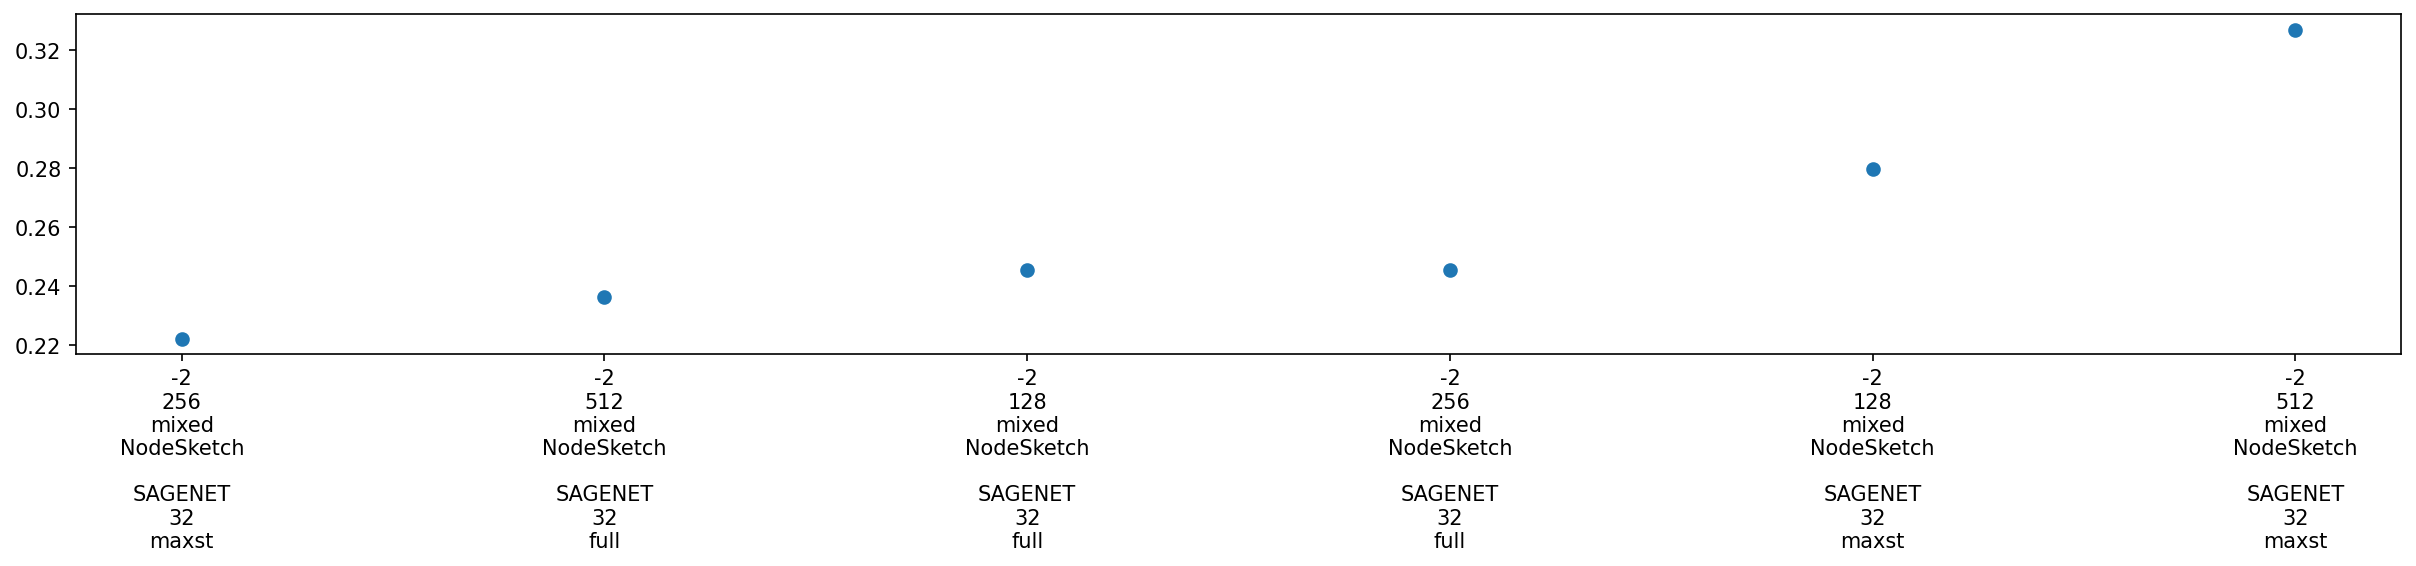

In [40]:
for name1, group1 in dffinal.groupby("Features"):
    for name2, group2 in group1.groupby("Model"):
        for name3, group3 in group2.groupby("Batch size"):
            print(group3)
            # PLOT N BEST MODELS
            n_best= 20
            metric = "MCC"
            metrics_list = ['Accuracy', 'Balanced_accuracy_score', 'F1macro', 'F1micro',
                   'F1weighted', 'MCC', 'precision', 'recall_score']
            group3[metrics_list] = group3[metrics_list].astype(np.float)
            nlargest_and_plot(dftemp=group3.nlargest(n_best, metric), metric=metric)
            break

In [41]:
dffinal[dffinal.index.map(lambda x: show_only(x)) == True].sort_values(by="MCC")

Unnamed: 0,Accuracy,Balanced_accuracy_score,F1macro,F1micro,F1weighted,MCC,precision,recall_score,Threshold,Hidden Channels,Features,Model,Graph type,Batch size,x_names


Unnamed: 0                                               MCC  \
-2_0.0001_512_500_49_False_GCN_0_maxst_32_[-Nod...  0.360468   
-2_0.0001_128_500_4267_True_GCNe_0_maxst_32_[-F...  0.381948   
-2_0.0001_128_500_4267_False_SAGENET_0_maxst_32...  0.387297   
-2_0.0001_512_500_4267_False_GCN_0_maxst_32_[-F...  0.399788   
-2_0.0001_512_500_4267_True_GCNe_0_maxst_32_[-F...  0.406703   
-2_0.0001_256_500_4267_True_GCNe_0_maxst_32_[-F...  0.436225   
-2_0.0001_128_500_4267_False_GCN_0_maxst_32_[-F...  0.475532   
-2_0.0001_512_500_4267_False_SAGENET_0_maxst_32...  0.477114   
-2_0.0001_256_500_4267_False_GCN_0_maxst_32_[-F...  0.500934   
-2_0.0001_256_500_49_False_GCN_0_maxst_32_[-Nod...  0.526479   

Unnamed: 0                                                                                x_names  
-2_0.0001_512_500_49_False_GCN_0_maxst_32_[-Nod...   -2\n512\nmixed\nNodeSketch\n\nGCN\n32\nmaxst  
-2_0.0001_128_500_4267_True_GCNe_0_maxst_32_[-F...     -2\n128\nmixed\nFeather\n\nGCNe\n32\nmax

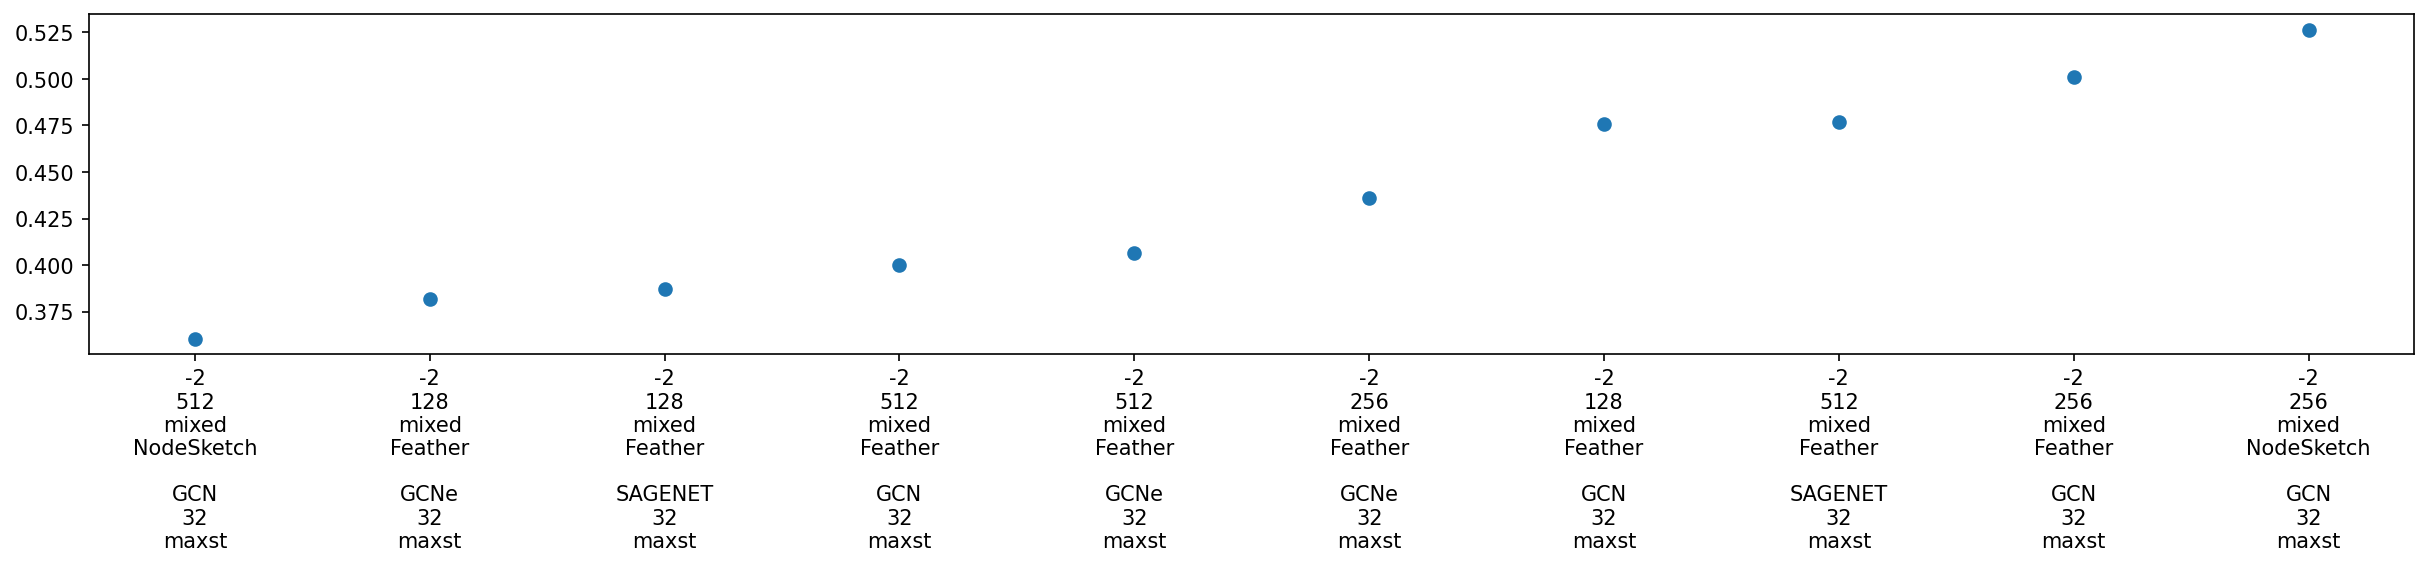

Unnamed: 0                                               MCC  \
-2_0.0001_128_500_4267_True_GCNe_0_maxst_64_[-F...  0.318584   
-2_0.0001_256_500_4267_True_GCNe_0_maxst_64_[-F...  0.362372   
-2_0.0001_256_500_49_False_SAGENET_0_full_64_[-...  0.378164   
-2_0.0001_128_500_4267_False_SAGENET_0_maxst_64...  0.418927   
-2_0.0001_512_500_4267_False_GCN_0_maxst_64_[-F...  0.431252   
-2_0.0001_512_500_4267_False_SAGENET_0_maxst_64...  0.436225   
-2_0.0001_512_500_4267_True_GCNe_0_maxst_64_[-F...  0.452500   
-2_0.0001_128_500_49_False_SAGENET_0_full_64_[-...  0.452500   
-2_0.0001_512_500_49_True_GCNe_0_maxst_64_[-Nod...  0.478848   
-2_0.0001_256_500_4267_False_GCN_0_maxst_64_[-F...  0.532061   

Unnamed: 0                                                                                  x_names  
-2_0.0001_128_500_4267_True_GCNe_0_maxst_64_[-F...       -2\n128\nmixed\nFeather\n\nGCNe\n64\nmaxst  
-2_0.0001_256_500_4267_True_GCNe_0_maxst_64_[-F...       -2\n256\nmixed\nFeather\n\nGCNe\n6

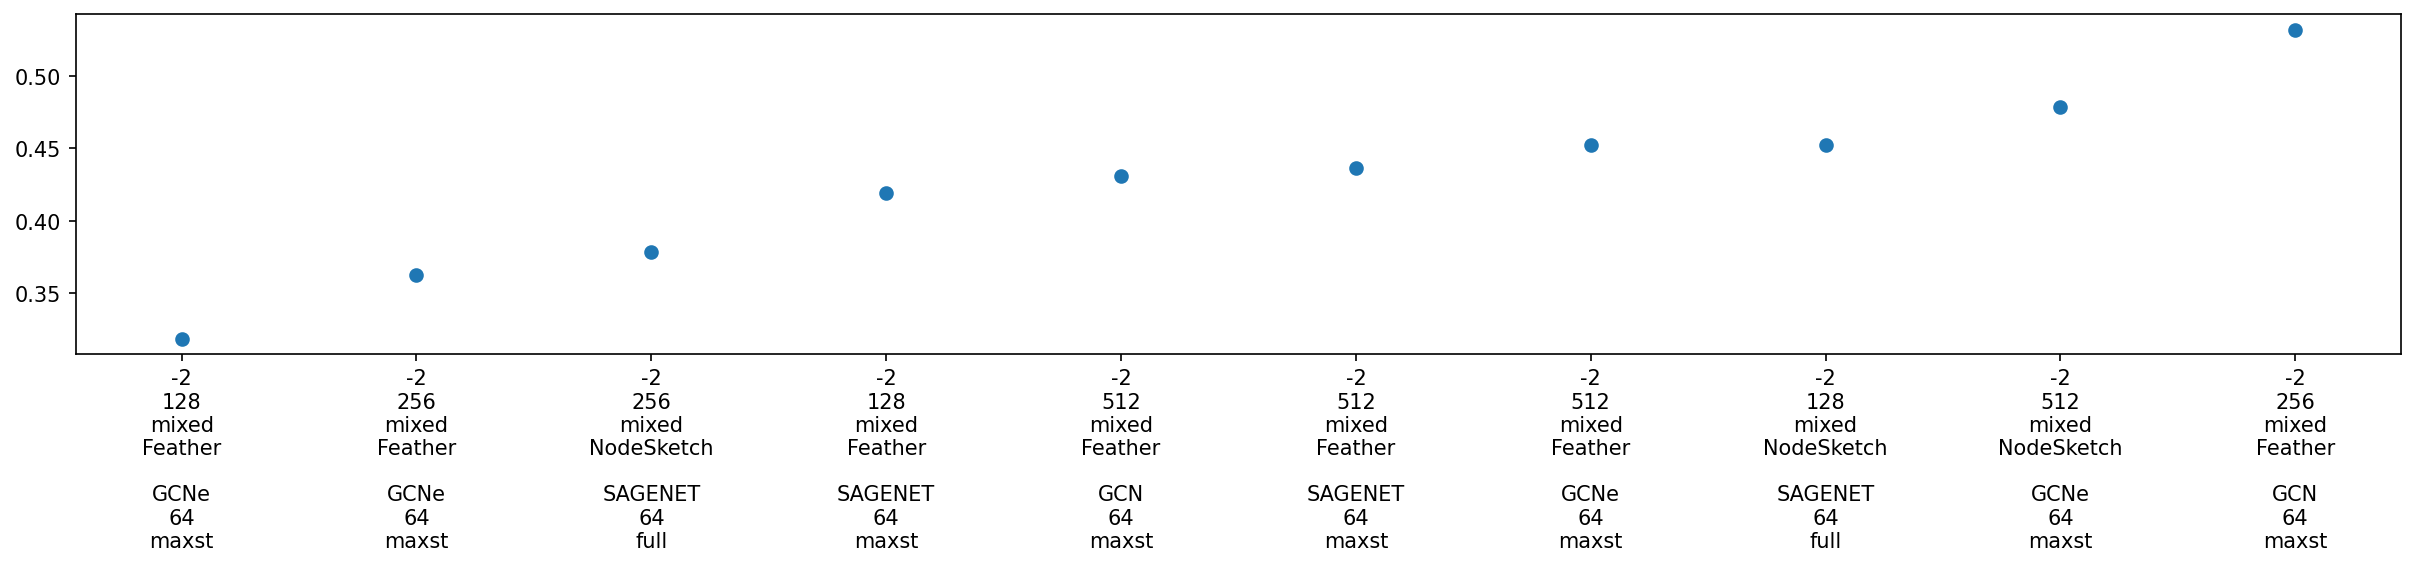

In [42]:
# PLOT IN GROUPS
for name, group in dffinal.groupby("Batch size"):
    nlargest_and_plot(dftemp=group, metric="MCC", tail=10)

Unnamed: 0                                               MCC  \
-2_0.0001_512_500_49_True_GCNe_0_maxst_32_[-Nod...  0.344439   
-2_0.0001_512_500_49_False_GCN_0_maxst_32_[-Nod...  0.360468   
-2_0.0001_256_500_4267_True_GCNe_0_maxst_64_[-F...  0.362372   
-2_0.0001_256_500_49_False_SAGENET_0_full_64_[-...  0.378164   
-2_0.0001_128_500_4267_True_GCNe_0_maxst_32_[-F...  0.381948   
-2_0.0001_128_500_4267_False_SAGENET_0_maxst_32...  0.387297   
-2_0.0001_512_500_4267_False_GCN_0_maxst_32_[-F...  0.399788   
-2_0.0001_512_500_4267_True_GCNe_0_maxst_32_[-F...  0.406703   
-2_0.0001_128_500_4267_False_SAGENET_0_maxst_64...  0.418927   
-2_0.0001_512_500_4267_False_GCN_0_maxst_64_[-F...  0.431252   
-2_0.0001_256_500_4267_True_GCNe_0_maxst_32_[-F...  0.436225   
-2_0.0001_512_500_4267_False_SAGENET_0_maxst_64...  0.436225   
-2_0.0001_512_500_4267_True_GCNe_0_maxst_64_[-F...  0.452500   
-2_0.0001_128_500_49_False_SAGENET_0_full_64_[-...  0.452500   
-2_0.0001_128_500_4267_False_GCN_0_maxst

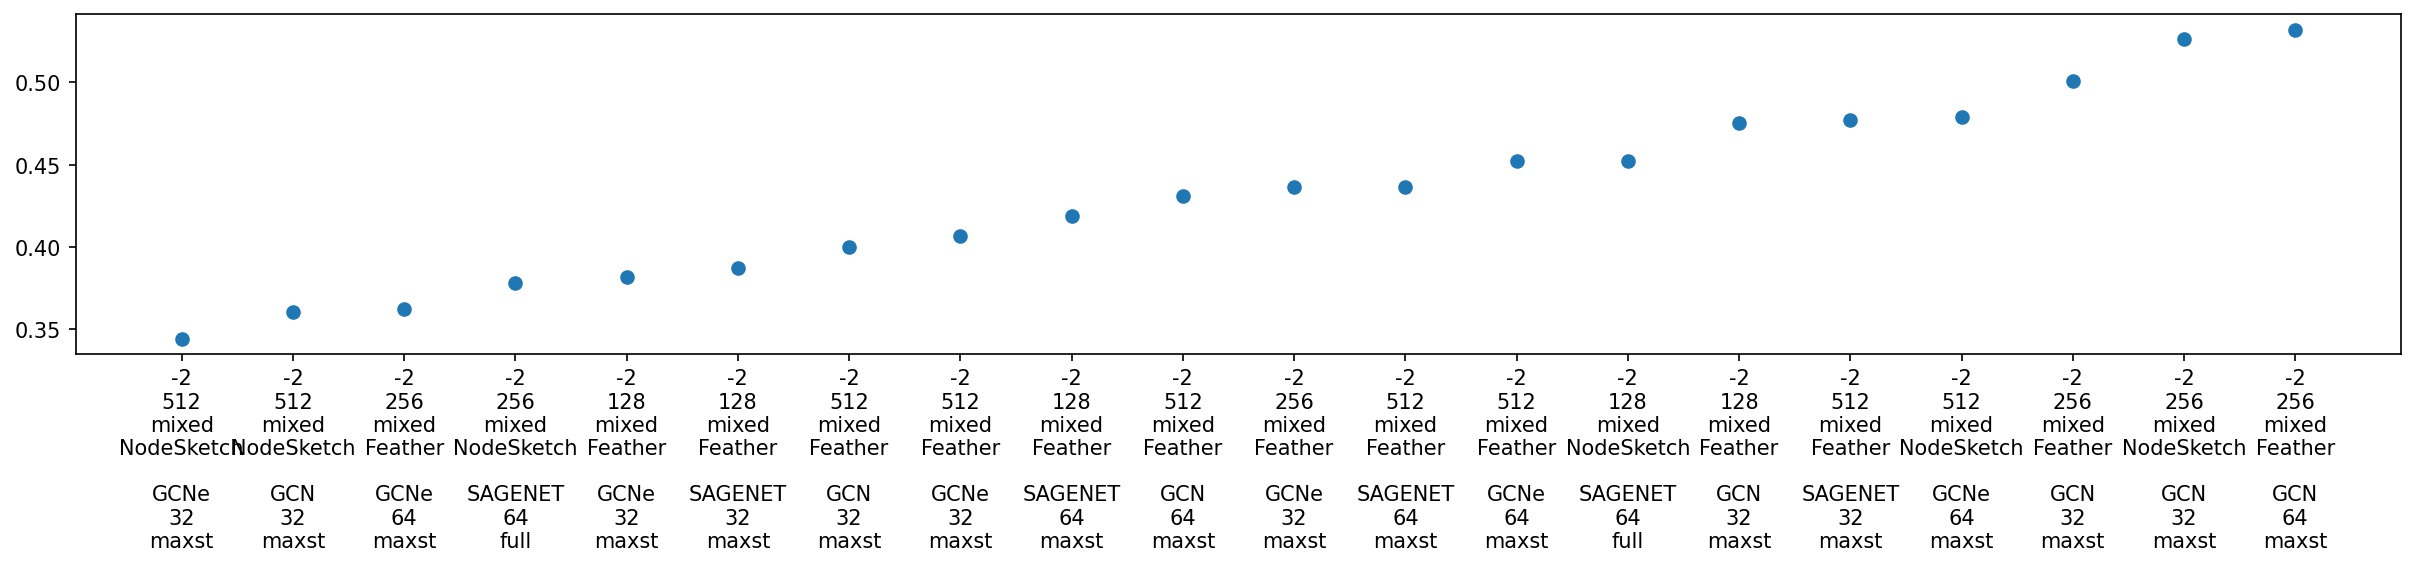

In [43]:
# PLOT N BEST MODELS
n_best= 20
metric = "MCC"
metrics_list = ['Accuracy', 'Balanced_accuracy_score', 'F1macro', 'F1micro',
       'F1weighted', 'MCC', 'precision', 'recall_score']
dffinal[metrics_list] = dffinal[metrics_list].astype(np.float)
nlargest_and_plot(dftemp=dffinal.nlargest(n_best, metric), metric=metric)

In [114]:
# dffinal["Threshold"] = [f"T: {x.split('_')[0]}" for x in dffinal.index.tolist()]
# dffinal["Hidden Channels"] = [f"HC: {x.split('_')[2]}" for x in dffinal.index.tolist()]
# dffinal["Features"] = [f"F: {feature_name_decoder(int(x.split('_')[4]), file_folder)}" for x in dffinal.index.tolist()] 
# dffinal["Model"] = [f"M: {x.split('_')[-1]}" for x in dffinal.index.tolist()]                       
# name_cols = ["Threshold", "Hidden Channels", "Features", "Model"]                       
# dffinal["x_names"] = ["\n".join(dffinal.loc[dffinal.index.tolist(), name_cols].values.tolist()[x]) for x in range(len(dffinal))]